# Deep Regression Estimating Bicycle Sharing

* Building a deep neural network to perform multivariate regression on number of community bicycles used;
* Dataset has 731 instances and 15 variables;
* 7 categorical and 5 numerical independent variables related to season and weather. 3 dependent variables, the number of bicycles used ("cnt"), the number of bicycles used by unregistered people ("casual") and the number of bicycles rented by registered people ("registered");
* Categorical variables are converted to one-hot encoding;
* Dataset used: https://www.kaggle.com/competitions/bike-sharing-demand/data

## Data Exploration

We start off by reading our dataset into a Pandas dataframe and printing it. We can see a couple of things:

1. ID-like variable "instant" does not present any useful information to us;
2. There are some categorical and some numerical variables;
3. 3 dependent variables: "casual", "registered" and "cnt";
4. "dteday" is a date variable that carries information already covered in other columns, e.g., "yr", "mnth" "season".

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error



bike_df = pd.read_csv("/content/bike_sharing_daily.csv")
bike_df

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,registered,cnt
0,1,1/1/2011,1,0,1,0,6,0,2,0.344167,0.805833,0.160446,331,654,985
1,2,1/2/2011,1,0,1,0,0,0,2,0.363478,0.696087,0.248539,131,670,801
2,3,1/3/2011,1,0,1,0,1,1,1,0.196364,0.437273,0.248309,120,1229,1349
3,4,1/4/2011,1,0,1,0,2,1,1,0.200000,0.590435,0.160296,108,1454,1562
4,5,1/5/2011,1,0,1,0,3,1,1,0.226957,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,12/27/2012,1,1,12,0,4,1,2,0.254167,0.652917,0.350133,247,1867,2114
727,728,12/28/2012,1,1,12,0,5,1,2,0.253333,0.590000,0.155471,644,2451,3095
728,729,12/29/2012,1,1,12,0,6,0,2,0.253333,0.752917,0.124383,159,1182,1341
729,730,12/30/2012,1,1,12,0,0,0,1,0.255833,0.483333,0.350754,364,1432,1796


We can also use Pandas' descriptive functions `info` and `describe` to try to grasp more information about our data.

The `info` function presents an important information: there are no null values in our dataset. We can say that because the count of non-null values is equal to the number of instances in the dataset for every variable.

In [ ]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  hum         731 non-null    float64
 11  windspeed   731 non-null    float64
 12  casual      731 non-null    int64  
 13  registered  731 non-null    int64  
 14  cnt         731 non-null    int64  
dtypes: float64(3), int64(11), object(1)
memory usage: 85.8+ KB


`describe` function provides insight on the data behavior by giving us the mean and standard deviation of each individual variable. Nonetheless, it is not very useful when analyzing categorical data. Mean, standard deviation and other descriptive statistics do not make much sense in categorical data, especially when it is everything nominal and nothing ordinal.

In [ ]:
bike_df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.972500,0.507463,3410.000000,6946.000000,8714.000000


Another way to check for null values in our data is combining Seaborn's `heatmap` function with Pandas' `isnull` function. If any value in the dataframe is null, the heatmap shows a square with different color for that value. Otherwise, as in our case, the heatmap has a unique color in its entirety.

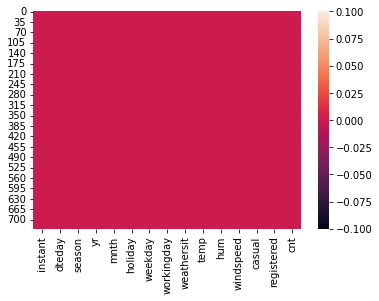

In [ ]:
sns.heatmap(bike_df.isnull())
plt.show()


---

The "dteday" date variable is redundant in this dataset. However, if we assign it as the index of the dataframe, we have a time series. We can plot the "cnt" variable against any time frequency available, be it weekly, monthly, quarterly or yearly.

After transforming "dteday", we can discard it. We also discard the 2 other dependent variables "casual" and "registered" since we are not interested in them. "instant" can also be removed because it is just a sequence with no semantics.

Ignoring the outliers present in the week-based plot, the 3 time frequencies selected show us similar information. For both years that we have data, there is a tendency to not have many bicycle rentals during the fourth quarter of the year. As this data was collected in the United States, we can assume that the drop in rentals is due to the winter season in that country.

In [ ]:
# Convert dteday variable to a datetime format that Pandas understands.
bike_df.dteday = pd.to_datetime(bike_df.dteday, format='%m/%d/%Y')
bike_df.index = pd.DatetimeIndex(bike_df.dteday)

# Drop variables useless to predict "cnt".
bike_df = bike_df.drop(['instant', 'casual', 'registered', 'dteday'], axis=1)

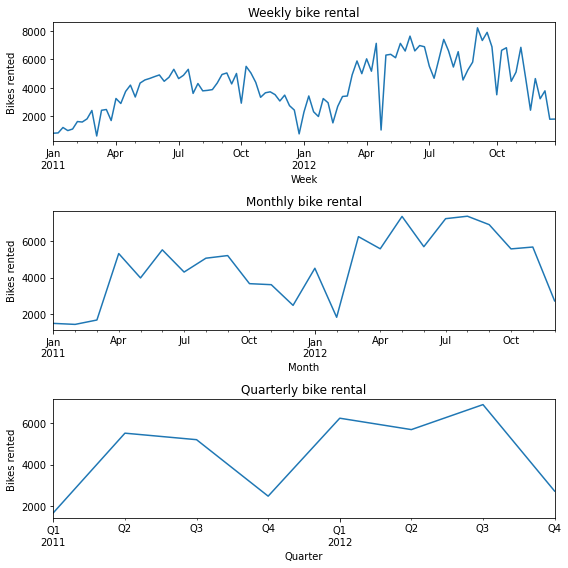

In [ ]:
# Figure with 3 subplots, one for each usable time frequency.
fig, axes = plt.subplots(3, 1, figsize=(8, 8))
# Use Pandas dataframe plot function to create the subplots directly.
bike_df['cnt'].asfreq('W').plot(ax=axes[0], title="Weekly bike rental",
                                xlabel="Week", ylabel="Bikes rented")
bike_df['cnt'].asfreq('M').plot(ax=axes[1], title="Monthly bike rental",
                                xlabel="Month", ylabel="Bikes rented")
bike_df['cnt'].asfreq('Q').plot(ax=axes[2], title="Quarterly bike rental",
                                xlabel="Quarter", ylabel="Bikes rented")
fig.tight_layout()
plt.show()

Correlation pair plots are very useful to try to check for collinear variables that can be discarded. They are also handy to understand which variables are correlated the most with the variable we want to predict.

In the pair plot below, we se that "temp" has some linear correlation with "cnt". In other words, the higher the temperature, the more bicycles are rented, which makes sense in real life too.

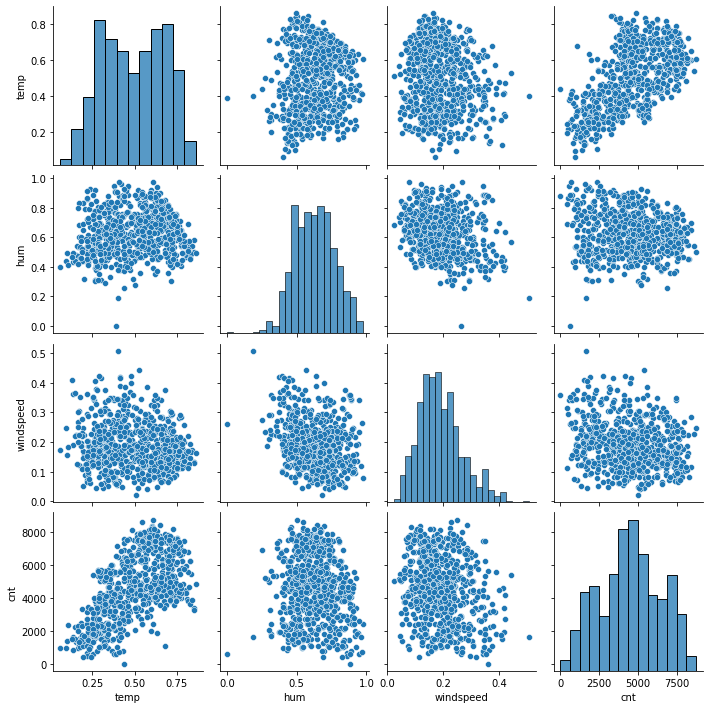

In [ ]:
# Select only numerical variables from the original dataframe as
# categorical variables are not of much use in correlation pair plots.
bike_df_numerical = bike_df[['temp', 'hum', 'windspeed', 'cnt']]

sns.pairplot(bike_df_numerical)
plt.show()

We can also use a heatmap to show correlation level with numbers. The heatmap ahead lead us to the same conclusion: temperature is highly correlated with number of rented bicycles; no other significant correlation can be observed.

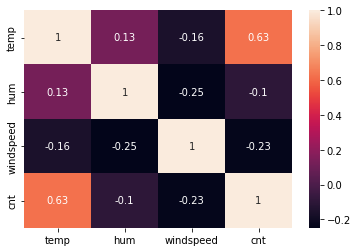

In [ ]:
# Argument "annot=True" to plot correlation value as well.        
sns.heatmap(bike_df_numerical.corr(), annot=True)
plt.show()

## Preprocessing Our Dataframe

It is very important to one-hot encode our categorical variables so that models trained on this data do not find orders of importance between the different nominal values.

After the new encoding, we can concatenate our categorical and our numerical variables.

Finally, we can separate the predicted variable from the predictor ones and split the data in train and test sets.

In [ ]:
# Get only categorical variables.
bike_df_categorical = bike_df[['season', 'yr', 'mnth', 'holiday', 'weekday',
                               'workingday', 'weathersit']]

# Instantiate Scikit-learn's one-hot encoder and transform variables.
one_hot = OneHotEncoder()
bike_df_categorical = one_hot.fit_transform(bike_df_categorical).toarray()
bike_df_categorical = pd.DataFrame(bike_df_categorical)

In [ ]:
# Drop index from numerical dataframe so that we can concatenate.
bike_df_numerical.reset_index(drop=True, inplace=True)
bike_df_onehot = pd.concat([bike_df_categorical, bike_df_numerical], axis=1)
bike_df_onehot

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,temp,hum,windspeed,cnt
0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.344167,0.805833,0.160446,985
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.363478,0.696087,0.248539,801
2,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.196364,0.437273,0.248309,1349
3,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.200000,0.590435,0.160296,1562
4,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.226957,0.436957,0.186900,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.254167,0.652917,0.350133,2114
727,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.253333,0.590000,0.155471,3095
728,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.253333,0.752917,0.124383,1341
729,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.255833,0.483333,0.350754,1796


In [ ]:
X = bike_df_onehot.iloc[:, :-1].values
y = bike_df_onehot.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

print(X_train.shape)
print(X_test.shape)

(621, 35)
(110, 35)


## Neural Network Building and Training

Note that our dataset is small and with few features. So, we do not need many neurons or layers in our model. If we do add too many of either, the model will easily overfit the training data.

Let us instantiate a simple sequential architecture following this rule of thumb: every layer will have half the neurons from the previous layer plus the number of neurons needed on the last layer, 1.

Every layer uses ReLU activation function, except for the last layer, that needs to have a linear activation to perform a regression.

Choices of number of epochs, learning rate and batch size also take into consideration the small size of the dataset.

In [ ]:
neural_regressor = tf.keras.models.Sequential()

# 18 neurons is half the amount of inputs + 1.
neural_regressor.add(tf.keras.layers.Dense(units=18, activation='relu',
                                           input_shape=(35,)))
neural_regressor.add(tf.keras.layers.Dense(units=10, activation='relu'))
neural_regressor.add(tf.keras.layers.Dense(units=6, activation='relu'))
neural_regressor.add(tf.keras.layers.Dense(units=1, activation='linear'))

neural_regressor.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_93 (Dense)            (None, 18)                648       
                                                                 
 dense_94 (Dense)            (None, 10)                190       
                                                                 
 dense_95 (Dense)            (None, 6)                 66        
                                                                 
 dense_96 (Dense)            (None, 1)                 7         
                                                                 
Total params: 911
Trainable params: 911
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# High learning rate of 0.1 because it is a simple dataset.
neural_regressor.compile(optimizer=tf.optimizers.Adam(0.1), loss='mse')

# 20 batches are used.
batch_size = len(X_train) // 20
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                           patience=10)

epochs_info = neural_regressor.fit(X_train,
                                   y_train,
                                   epochs=1000,
                                   batch_size=batch_size,
                                   validation_split=0.15,
                                   callbacks=[early_stopping_callback])

Epoch 1/1000
17/17 [==============================] - 1s 27ms/step - loss: 19985494.0000 - val_loss: 4435019.0000
Epoch 2/1000
17/17 [==============================] - 0s 2ms/step - loss: 4544435.5000 - val_loss: 2761980.5000
Epoch 3/1000
17/17 [==============================] - 0s 3ms/step - loss: 2029244.1250 - val_loss: 1048205.3750
Epoch 4/1000
17/17 [==============================] - 0s 3ms/step - loss: 1187282.1250 - val_loss: 491172.4375
Epoch 5/1000
17/17 [==============================] - 0s 3ms/step - loss: 904463.6875 - val_loss: 389996.2500
Epoch 6/1000
17/17 [==============================] - 0s 3ms/step - loss: 849105.8750 - val_loss: 377208.1250
Epoch 7/1000
17/17 [==============================] - 0s 3ms/step - loss: 823840.0000 - val_loss: 381354.9062
Epoch 8/1000
17/17 [==============================] - 0s 2ms/step - loss: 830547.8125 - val_loss: 374958.9062
Epoch 9/1000
17/17 [==============================] - 0s 2ms/step - loss: 813450.5000 - val_loss: 407652.8438
E

We see on the loss progression plot that our model converges very fast, before 10 epochs. This is due to the simplicity of the dataset and the high learning rate setting.

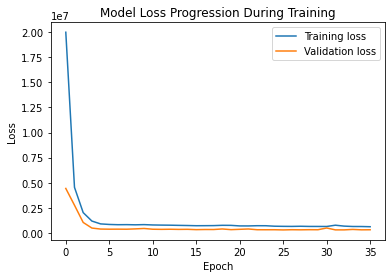

In [ ]:
plt.plot(epochs_info.history['loss'])
plt.plot(epochs_info.history['val_loss'])
plt.title("Model Loss Progression During Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training loss", "Validation loss"])
plt.show()

## Model Evaluation

By plotting the model's predictions against the true values for this dataset we get a diagonal-shaped projection. This indicates that our model has a very good performance as its responses bear a high linear correlation to the real values.

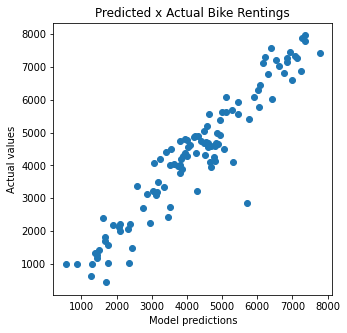

In [ ]:
# Get model's test set regressions to plot against ground-truth values.
y_pred = neural_regressor.predict(X_test)

plt.figure(figsize=(5, 5))
plt.scatter(y_pred, y_test)
plt.title("Predicted x Actual Bike Rentings")
plt.xlabel("Model predictions")
plt.ylabel("Actual values")
plt.show()

Looking for a more numerical evaluation of our model's performance, we can use the R2 score and some error measures.

Unfortunately, mean squared error (MSE) and root mean squared error (RMSE) by themselves are not of much help. Their values are arbitrary and too much dependent on data domain knowledge.

However, mean absolute error (MAE) indicates that our model is not doing amazingly, but has a solid performance. We can say that by taking the MAE value and comparing it to the magnitude (max - min), mean and standard deviation of the dependent variable "cnt", previously reported by Pandas' `describe` function:

- MAE: 473.23
- Magnitude: 8714 - 22 = 8692
- Mean: 4504.34
- Standard deviation: 1937.21

MAE is approximately: 5% of the magnitude, 10% of the mean and 24% of the standard deviation. Nice results, considering that our predictions are falling close to the mean, missing by less than a quarter of the standard deviation and our errors are very small compared to the maximum possible error (magnitude).

Lastly, our R2 score is 0.89. Very close to a perfect model that has 1.0 R2 score. Very far from a random prediction model that has 0.0 R2 score.

In [ ]:
# Use the off-the-shelf MAE, MSE, RMSE and R2 score functions from
# Scikit-learn.
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Get number of instances and features and calculate the adjusted
# R2 score.
n = X_test.shape[0]
k = X_test.shape[1]
adjusted_r2 = 1 - ((1 - r2) * (n - 1)) / (n - k - 1)

print("Mean Absolute Error: ", mae)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", rmse)
print("R2 score: ", r2)
print("Adjusted R2 score: ", adjusted_r2)

Mean Absolute Error:  473.23127718838776
Mean Squared Error:  384297.41236008785
Root Mean Squared Error:  619.9172625117709
R2 score:  0.8956431803921663
Adjusted R2 score:  0.8462852251722449
